
## Automated Wheat Counter
by Marsh [ @vbookshelf ] <br>
30 May 2020

### Why do we need an automated wheat counter?

Because manual counting is a path to the dark side. Whether it's counting cells on a microscope slide or counting wheat heads on a photo - the process is tiring and frustrating. The scientists in this music video express it best.

https://www.youtube.com/watch?v=qgu865oCYw4

<div align="center"><iframe width="560" height="315" src="https://www.youtube.com/embed/qgu865oCYw4?rel=0" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></div>

## Objective

My objective for this project was to build and deploy a flask web app that can automatically count wheat heads on wheat photos.

This tool could help researchers get quick estimates of wheat density.

<br>


<img src="http://wheatcounter.test.woza.work/assets/holdout_image_11.png" width="350"></img>

<h5 align="center">Fig. 1 - Prediction on image from holdout set</h5>


<br>

Fig. 1 above is an actual prediction that the model made on image 667b4a999.jpg. This image is part of the holodout set. Also, it's from the arvalis_2 source - arvalis_2 images were not part of the training set. Counting the number of wheat heads on this image would be hard for a human to do accurately. The correct number of wheat heads is 11. The app predicted 12.

<br>

> Live Demo<br>
> http://wheatcounter.test.woza.work/<br>
> 
> Github<br>
> https://github.com/vbookshelf/Automated-Wheat-Counter

The demo will be live until 30 June 2020.

This app accepts only one image at a time. However, the code could be modified to support batch analysis. A user could then select multiple images. The app would output a prediction for each image and a total count off all wheat heads in the batch.



## Approach

This solution uses two models - a segmentation model and a regression model. Both models were trained at the same time. 



<img src="http://wheatcounter.test.woza.work/assets/images_and_masks.png" height="200"></img>

<h5 align="center">Fig. 2 - Segmentation and Regression model images and masks</h5>

<br>
<br>
**For each training loop the process is as follows**:

A pre-processed 512x512x3 RGB image is input into the segmentation model. This model outputs a 512x512x1 segmentation mask with matrix values that are probabilities between zero and one. This mask is then thresholded to convert it into a binary mask i.e. the matrix now has values that are either zero or one. 

This binary mask and the pre-processed RGB input image are then multiplied. As a result any areas of the input image that are not inside the segmentation areas (i.e. not wheat heads) get assigned a value of zero. In other words they become black. In this way image patterns that are specific to certain sources (world regions where the photos were taken) are removed.

This multiplied image is then fed into the regression model. The regression model predicts the number of wheat heads.

The segmentation model is a Unet with a pre-trained resnet34 encoder. The regression model is a pre-trained resnet34. I used image augmentation to help the models generalize. The models were trained for 30 epochs with a constant learning rate of 0.0001 - dice loss for the segmentation model and mse loss for the regression model.

Although there are two models, for the rest of this notebook I will be referring to them both as "the model".




## Validation Strategy

In order to check how well the solution was generalizing I split the training and validation images based on their source.

The model was trained on images from these sources:<br>
(2969 images)

- arvalis_1 (France)
- arvalis_3 (France)
- inrae_1 (France)
- ethz_1 (Switzerland)
- rres_1 (UK)

It was validated on images from these sources:<br>
(389 images)

- usask_1 (Canada)
- arvalis_2 (France)


Holdout set:<br>
(15 images)
- usask_1 (Canada)
- arvalis_2 (France)

## Validation Results

> **Total val set percentage error**: 20.5 %
> 
> This is the sum of the absolute counting error for all 389 validation images divided by the total number of wheat heads in the vaidation set.

> **Val set MAE**: 5.03<br>
>
> **usask_1 MAE**: 3.89<br>
> **arvalis_2 MAE**: 6.16<br>



> Could this model be a helpful tool? A practical way to determine this would be to compare it's percentage error to human-level performance.
>
> Let's define human-level performance as the percentage error that could be achieved by a typical human who is counting wheat heads on a dataset of images. A typical human could achieve 0% error on one image but, because of the tedious nature of counting, the error would be higher when a human has to manually analyze a large batch of images.
>
> **If a human were to manually count the wheat heads in the validation set (389 images), what would be his or her percentage error? **
>
> If this model's error is lower, then we could conclude that it is a viable counting tool. This is because even though the model's counting accuracy is not perfect, it's still better and faster than a typical human. The model's ability to generalize to regions that were not part of the training or validation data would still need to be tested.



<br>


*[Note: The above values change each time this notebook is run. They may not match what you see below.]*

## Deployment Strategy

The app frontend and backend are on different servers. They communicate using API request/response calls.

### 1- Frontend

The frontend is a simple website. It takes a user image as input. It then sends this image to the API server (backend) for prediction. When the prediction (response) is received, the frontend website displays it.

### 2- Backend

Machine learning web apps work nicely when tested on a local machine (localhost). But the true test comes when the model is deployed to a real production server. This process can be frustrating due package dependency issues.

Through experimentation I've found that using a rented server plus Docker plus Pytorch is a robust deployment approach. Although it's not cheap, this backend strategy can be set up without headaches and it works reliably. It's also easy to scale i.e. to support high workloads it's easy to run an app on mutiple servers with load balancing.

The server for this app has 2 vCPU's and 4GB of RAM. It's running Ubuntu 16.04. 

The setup is a Docker container that's made up of Flask, Nginx and uWSgi. Flask is where the python code is stored. Nginx is the web server and uWSGI allows Flask and Nginx to talk. By using Docker, the model and all it's dependencies (incl Flask and Nginx) are in the same container.

The trend now is to outsource the backend to third party companies. However, as server side code becomes highly complex, I believe that in order to ensure service reliability the owner of the app needs to control the entire workflow - from the server to the end user. 

## Install Packages

We'll be using the excellent segmentation-models-pytorch package created by Pavel Yakubovsky.<br>
https://github.com/qubvel/segmentation_models.pytorch

In [1]:
! pip install segmentation-models-pytorch

     |████████████████████████████████| 42 kB 402 kB/s 
     |████████████████████████████████| 58 kB 2.6 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=6bde491752d041247bd3e6b556047d3201bbdf3cb5e32c4708478a7d68eb05ca
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=332ef93d35f190cd417979bed1c7845cb2e1edc80f1173da233369cf42d78caf
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import os

import ast


import cv2
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# set a seed value
torch.manual_seed(555)

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR


import albumentations as albu
from albumentations import Compose


from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


import matplotlib.pyplot as plt
%matplotlib inline

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

# Note: Pytorch uses a channels-first format:
# [batch_size, num_channels, height, width]

print(torch.__version__)
print(torchvision.__version__)

1.5.0
0.6.0a0+82fd1c8


In [3]:
os.listdir('../input/')

['global-wheat-detection', 'wheat-detection-comp-original-data']

In [4]:
BACKBONE = 'resnet34'

IMAGE_HEIGHT_ORIG = 1024
IMAGE_WIDTH_ORIG = 1024
IMAGE_CHANNELS_ORIG = 3

IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
IMAGE_CHANNELS = 3

BATCH_SIZE = 8

SAMPLE_SIZE = 15

NUM_EPOCHS = 30

THRESHOLD = 0.7

LRATE = 0.0001

# Check the number of available cpu cores.
# This variable is used to set the num workers in the data loader.
NUM_CORES = os.cpu_count()

NUM_CORES

2

## Define the device

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


## Helper Functions

In [6]:

def create_mask(image_id, image_height, image_width):
    """
    Input: image_id
    Output: Image mask containing all the bbox masks.
    """
    
    # filter out all rows with the image_id
    df = df_data[df_data['image_id'] == image_id]

    # create blank mask
    mask = np.zeros((image_height, image_width, 1))

    # get a list of all bbox values
    bbox_list = list(df['bbox'])


    # loop over the bbox list
    for bbox_string in bbox_list:

        bbox = ast.literal_eval(bbox_string) 
        
        # First we check if a mask exists.
        # If not a blank mask is returned.
        if (bbox_string[0] != '[') or (len(bbox) == 0):

            pass

        else:

            # get the bounding box
            # ast.literal_eval converts '[...]' to [...]
            bbox = ast.literal_eval(bbox_string) 

            x = int(bbox[0])
            y = int(bbox[1])
            w = int(bbox[2])
            h = int(bbox[3])

            # add the bbox mask to the blank mask created above
            mask[y:y+h, x:x+w] = 1
    
    return mask





def multiply_masks_and_images(images, thresh_masks):
    
    """
    Trying to do this multiplication with Pytorch tensors
    did not produce the result that I wanted. Therefore, here I am
    converting the tensors to numpy, doing the multiplication, and 
    then converting back to pytorch.
    
    """

    # convert from torch tensors to numpy
    np_images = images.cpu().numpy()
    np_thresh_masks = thresh_masks.cpu().numpy()

    # reshape
    np_images = np_images.reshape((-1, 512, 512, 3))
    np_thresh_masks = np_thresh_masks.reshape((-1, 512, 512, 1))


    # multiply the mask by the image
    modified_images = np_thresh_masks * np_images

    # change shape to channels first to suit pytorch
    #modified_images = modified_images.transpose((2, 0, 1))
    modified_images = modified_images.reshape((-1, 3, 512, 512))

    # convert to torch tensor
    modified_images = torch.tensor(modified_images, dtype=torch.float)

    return modified_images



## Prepare the Data

In [7]:
# I saved the original competition data as a Kaggle dataset.
# Here I'm using that dataset as the data source.

base_path = '../input/wheat-detection-comp-original-data/global-wheat-detection/'

os.listdir(base_path)

['train', 'sample_submission.csv', 'train.csv', 'test']

In [8]:
path = base_path + 'train.csv'

df_data = pd.read_csv(path)

print(df_data.shape)

df_data.head()

(147793, 5)


image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

### Create new columns

In [9]:
# [xmin, ymin, width, height]


def extract_width(x):
    
    # convert the string to a python list
    bbox = ast.literal_eval(x) 
    
    # get the width
    w = int(bbox[2])
    
    return w



def extract_height(x):
    
    # convert the string to a python list
    bbox = ast.literal_eval(x) 
    
    # get the width
    h = int(bbox[3])
    
    return h



# Create new columns
df_data['w'] = df_data['bbox'].apply(extract_width)
df_data['h'] = df_data['bbox'].apply(extract_height)

df_data.head()

image_id  width  height                         bbox   source    w    h
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1   56   36
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1  130   58
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1   74  160
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1  109  107
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1  124  117

### Clean the data

In [10]:
# Filter out the big masks.
# Use 500px as the limit.

df_data = df_data[df_data['w'] < 500]
df_data = df_data[df_data['h'] < 500]

In [11]:
# Filter out the very small masks.
# Use 20px as the limit.

df_data = df_data[df_data['w'] >= 20]
df_data = df_data[df_data['h'] >= 20]

In [12]:
# Check how many rows now exist

df_data.shape

(146532, 7)

### Get the num wheat heads on each image

We had to clean the data first before doing this. The resulting dataframe will need to be merged with the train and val data.

In [13]:
df_masks = df_data.copy()

# Create a new column
df_masks['num_masks'] = 1

df_masks = df_masks[['image_id', 'num_masks']]

print(df_masks.shape)

df_masks.head()

(146532, 2)


image_id  num_masks
0  b6ab77fd7          1
1  b6ab77fd7          1
2  b6ab77fd7          1
3  b6ab77fd7          1
4  b6ab77fd7          1

In [14]:
# Create a dataframe showing num wheat heads on each unique image

df_masks = df_masks.groupby('image_id').sum()

df_masks = df_masks.reset_index()

df_masks.head()

image_id  num_masks
0  00333207f         55
1  005b0d8bb         20
2  006a994f7         25
3  00764ad5d         41
4  00b5fefed         25

### Get lists of unique images

In [15]:
# List the data sources

df_data['source'].unique()

array(['usask_1', 'arvalis_1', 'inrae_1', 'ethz_1', 'arvalis_3', 'rres_1',
       'arvalis_2'], dtype=object)

In [16]:
# Filter out all images
df_usask_1 = df_data[df_data['source'] == 'usask_1']
# Drop duplicate image_id values
df_usask_1 = df_usask_1.drop_duplicates(subset='image_id', keep='first', inplace=False)

# Filter out all images
df_arvalis_1 = df_data[df_data['source'] == 'arvalis_1']
# Drop duplicate image_id values
df_arvalis_1 = df_arvalis_1.drop_duplicates(subset='image_id', keep='first', inplace=False)

# Filter out all images
df_arvalis_2 = df_data[df_data['source'] == 'arvalis_2']
# Drop duplicate image_id values
df_arvalis_2 = df_arvalis_2.drop_duplicates(subset='image_id', keep='first', inplace=False)

# Filter out all images
df_arvalis_3 = df_data[df_data['source'] == 'arvalis_3']
# Drop duplicate image_id values
df_arvalis_3 = df_arvalis_3.drop_duplicates(subset='image_id', keep='first', inplace=False)

# Filter out all images
df_inrae_1 = df_data[df_data['source'] == 'inrae_1']
# Drop duplicate image_id values
df_inrae_1 = df_inrae_1.drop_duplicates(subset='image_id', keep='first', inplace=False)

# Filter out all images
df_ethz_1 = df_data[df_data['source'] == 'ethz_1']
# Drop duplicate image_id values
df_ethz_1 = df_ethz_1.drop_duplicates(subset='image_id', keep='first', inplace=False)

# Filter out all images
df_rres_1 = df_data[df_data['source'] == 'rres_1']
# Drop duplicate image_id values
df_rres_1 = df_rres_1.drop_duplicates(subset='image_id', keep='first', inplace=False)



print('usask_1:', df_usask_1.shape) # Use for validation
print('arvalis_1:', df_arvalis_1.shape)
print('arvalis_2:', df_arvalis_2.shape) # Use for validation
print('arvalis_3:', df_arvalis_3.shape)
print('inrae_1:', df_inrae_1.shape)
print('ethz_1:', df_ethz_1.shape)
print('rres_1:', df_rres_1.shape)


usask_1: (200, 7)
arvalis_1: (1055, 7)
arvalis_2: (204, 7)
arvalis_3: (559, 7)
inrae_1: (176, 7)
ethz_1: (747, 7)
rres_1: (432, 7)


### Display one image and mask

(1024, 1024, 3)


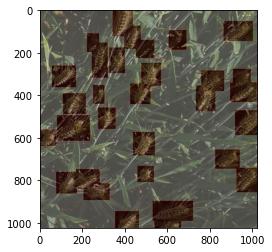

In [17]:
# Print one image

image_id = '42e6efaaa'

path = base_path + 'train/' + image_id + '.jpg'


mask = create_mask(image_id, 1024, 1024)
mask = mask[:,:,0]

image = plt.imread(path)

print(image.shape)

plt.imshow(image, cmap='Greys')
plt.imshow(mask, cmap='Reds', alpha=0.3)

plt.show()

## Train Test Split

In [18]:
# Train
    # df_arvalis_1
    # df_arvalis_3
    # df_inrae_1
    # df_ethz_1
    # df_rres_1



# Val
    # df_usask_1
    # df_arvalis_2

    
    
# Create the train set
df_train = pd.concat([df_arvalis_1, df_arvalis_3, df_inrae_1, df_ethz_1, df_rres_1], axis=0)


# Create the val set
df_val = pd.concat([df_usask_1, df_arvalis_2], axis=0)


print(df_train.shape)
print(df_val.shape)

(2969, 7)
(404, 7)


## Merge df_masks with df_train and df_val

This is so that we have a column showing num wheat heads on each image.

In [19]:
# We perform an inner join (intersection).
# Only image_id values that are common to both dataframes will be kept. Other rows will be deleted.
# Codebasics tutorial: https://www.youtube.com/watch?v=h4hOPGo4UVU

df_train = pd.merge(df_train, df_masks, on='image_id', how='inner')

df_val = pd.merge(df_val, df_masks, on='image_id', how='inner')

# Select the columns we want.
cols = ['image_id', 'source', 'num_masks']
df_train = df_train[cols]
df_val = df_val[cols]

print(df_train.shape)
print(df_val.shape)

(2969, 3)
(404, 3)


In [20]:
df_train.head()

image_id     source  num_masks
0  44c60402e  arvalis_1         60
1  6e3da4ae3  arvalis_1         47
2  d8616bdd1  arvalis_1         41
3  d1effa7a5  arvalis_1         42
4  f121ee695  arvalis_1         38

In [21]:
df_val.head()

image_id   source  num_masks
0  b6ab77fd7  usask_1         47
1  b53afdf5c  usask_1         45
2  7b72ea0fb  usask_1         41
3  91c9d9c38  usask_1         33
4  41c0123cc  usask_1         34

## Create a holdout test set

This will be set aside and won't be used during training and validation. We could use these images later to check how the trained model performs on unseen data and to test the app. We will set aside 15 images from df_val as a holdout set.

In [22]:
df_test = df_val.sample(n=SAMPLE_SIZE, random_state=101)

print(df_test.shape)

df_test.head(15)

(15, 3)


image_id     source  num_masks
114  04b7f3a15    usask_1         29
43   e99cca2a3    usask_1         22
139  7fc9fe138    usask_1         15
202  667b4a999  arvalis_2         11
130  05dfa9bb1    usask_1         31
370  72c3714bc  arvalis_2         30
369  da3cfa3d4  arvalis_2         30
305  e6989f6c7  arvalis_2         13
353  ff5c9104a  arvalis_2         17
141  13a368f78    usask_1         46
117  0594af5a7    usask_1         27
331  375a4795b  arvalis_2         28
372  1bcb0e91e  arvalis_2         25
89   0d5525a7b    usask_1         14
216  467e7283e  arvalis_2         29

In [23]:
df_val.shape

(404, 3)

In [24]:
# Remove the test images from df_val

test_images_list = list(df_test['image_id'])
 
df_val = df_val[~df_val['image_id'].isin(test_images_list)] # This line means: is not in

df_val.shape

(389, 3)

In [25]:
# Shuffle

df_train = shuffle(df_train)

df_val = shuffle(df_val)

## Save the dataframes as compressed csv files

In [26]:
df_data.to_csv('df_data.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

df_test.to_csv('df_test.csv.gz', compression='gzip', index=False)

In [27]:
# Check that the dataframes have been saved.
!ls

__notebook__.ipynb  df_test.csv.gz   df_val.csv.gz
df_data.csv.gz	    df_train.csv.gz


## Set up and test the augmentations

In [28]:

import albumentations as albu

# Define the augmentations

def get_training_augmentation():
    
    train_transform = [
    albu.Flip(always_apply=False, p=0.8),
    albu.RandomRotate90(always_apply=False, p=0.8),
    albu.Blur(blur_limit=7, always_apply=False, p=0.3),
    albu.OneOf([
        albu.RandomContrast(),
        albu.RandomGamma(),
        albu.RandomBrightness(),
        ], p=0.5),
    albu.OneOf([
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        albu.GridDistortion(),
        albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.5),
   
    ]
  
    return albu.Compose(train_transform)




def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
    ]
    return albu.Compose(_transform)
   

0
255
(1024, 1024, 3)


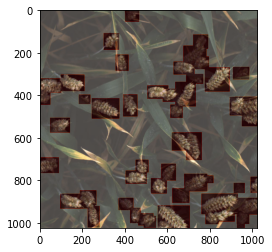

In [29]:
# Display an image and mask
# ==========================

image_id = '7d5af5b74'

path = '../input/global-wheat-detection/train/' + image_id + '.jpg'


mask = create_mask(image_id, 1024, 1024)
mask = mask[:,:,0]

image = plt.imread(path)

print(image.min())
print(image.max())
print(image.shape)

plt.imshow(image, cmap='Greys')
plt.imshow(mask, cmap='Reds', alpha=0.3)

plt.show()

0
255
(1024, 1024, 3)
(1024, 1024, 1)


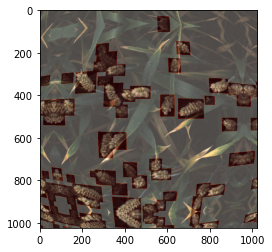

In [30]:
# Display an AUGMENTED image
# =============================

image_id = '7d5af5b74'
path = '../input/global-wheat-detection/train/' + image_id + '.jpg'

image = plt.imread(path)
mask = create_mask(image_id, 1024, 1024)

augmentation = get_training_augmentation()

sample = augmentation(image=image, mask=mask)
image, mask = sample['image'], sample['mask']


print(image.min())
print(image.max())

print(image.shape)
print(mask.shape)



plt.imshow(image, cmap='Greys')
plt.imshow(np.squeeze(mask), cmap='Reds', alpha=0.3)

plt.show()

-2.1179039301310043
2.6399999999999997
(1024, 1024, 3)
(1024, 1024, 1)


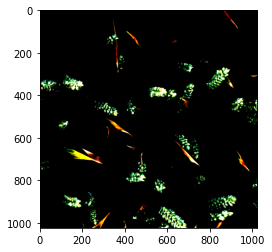

In [31]:
# Display a PRE-PROCESSED image
# ==============================


image_id = '7d5af5b74'
path = '../input/global-wheat-detection/train/' + image_id + '.jpg'

image = plt.imread(path)
mask = create_mask(image_id, 1024, 1024)




from segmentation_models_pytorch.encoders import get_preprocessing_fn

# Initialize the preprocessing function
preprocessing_fn = get_preprocessing_fn(BACKBONE, pretrained='imagenet')

preprocessing = get_preprocessing(preprocessing_fn)

sample = preprocessing(image=image, mask=mask)
image, mask = sample['image'], sample['mask']



print(image.min())
print(image.max())

print(image.shape)
print(mask.shape)



plt.imshow(image)

# Uncomment the next line to see a mask overlayed on the pre-processed image.
# plt.imshow(np.squeeze(mask), cmap='Reds', alpha=0.3)

plt.show()

## Set up the DataLoader

In [32]:
# Reset the indices

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [33]:
class CompDataset(Dataset):
    
    def __init__(self, df, augmentation=None, preprocessing=None):
        self.df_data = df
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
        
        
    def __getitem__(self, index):
        image_id = self.df_data.loc[index, 'image_id']
        
        image_path = base_path + 'train/'
        

        # set the path to the image
        path = image_path + image_id + '.jpg'
        
        # Create the image
        # ------------------


        # read the image
        image = cv2.imread(path)

        # convert to from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # resize the image
        image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))

        
        
        # Create the mask
        # ------------------
        
        # create the mask
        mask = create_mask(image_id, 1024, 1024)

        # resize the mask
        mask = cv2.resize(mask, (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # create a channel dimension
        mask = np.expand_dims(mask, axis=-1)
        
  
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            

    
        # Swap color axis
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        mask = mask.transpose((2, 0, 1))
        
        # convert to torch tensor
        image = torch.tensor(image, dtype=torch.float)
        mask = torch.tensor(mask, dtype=torch.float)
        
        
        # Create the regression target.
        cols = ['num_masks']
        
        target = torch.tensor(self.df_data.loc[index, cols], dtype=torch.float)
        
        
        sample = (image, mask, target)
        
        
        return sample
    
    
    def __len__(self):
        return len(self.df_data)
    

In [34]:
# Test the dataloaders

from segmentation_models_pytorch.encoders import get_preprocessing_fn

# Initialize the preprocessing function
preprocessing_fn = get_preprocessing_fn(BACKBONE, pretrained='imagenet')


train_data = CompDataset(df_train, augmentation=get_training_augmentation(), 
                        preprocessing=get_preprocessing(preprocessing_fn))

val_data = CompDataset(df_val, augmentation=None, 
                        preprocessing=get_preprocessing(preprocessing_fn))


train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                           num_workers=NUM_CORES
                                            )

val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                           num_workers=NUM_CORES
                                            )



In [35]:
# get one of train batch
images, masks, targets = next(iter(train_loader))

print(images.shape)
print(masks.shape)
print(targets.shape)

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])
torch.Size([8, 1])


tensor(-2.1179)
tensor(2.2318)


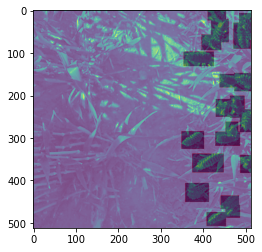

In [36]:
# display an image from the batch
image = images[0, 0, :, :]
mask = masks[0, 0, :, :]

print(image.min())
print(image.max())

plt.imshow(image)
plt.imshow(mask, cmap='Reds', alpha=0.3)

plt.show()

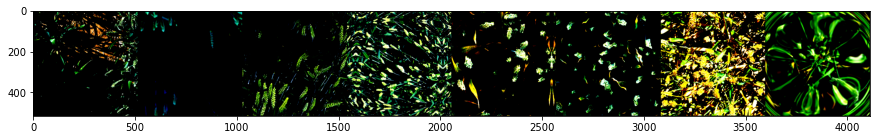

In [37]:
# Display the image batch in a grid

grid = torchvision.utils.make_grid(images) # nrows is the number of classes

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.show()

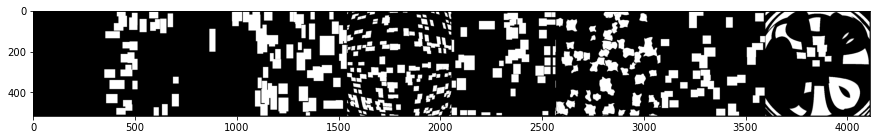

In [38]:
# Display the mask batch in a grid

grid = torchvision.utils.make_grid(masks) # nrows is the number of classes

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.show()

## Model Architecture

Here we will set up two models - a segmentation model and a regression model. We will train both models at the same time. The output from the first model will be processed and then used as an input for the second model. The final output will be a prediction of how many wheat heads are on each image.

In [39]:
# Model Workflow


# (1) Segmentation Model
# .......................

# seg_model Input: 
# 3x512x512 RGB pre-processed image

# seg_model Output:
# Mask with float values in range 0 to 1



# (2) Intermediate Step
# .......................

# Threshold the seg_model output to obtain a binary mask.
# Take the image that was used as the input to the seg_model and multiply it by the binary mask.



# (3) Regression Model
# .......................
# Resnet34 was used as the seg_model encoder therefore, we are using resnet34 in the reg_model also
# so that the image pre-processing will not need to be done again.

# reg_model Input: 
# 3x512x512 pre-processed image that has been multiplied by a binary mask.

# reg_model Output: 
# Number of wheat heads on the image.


## seg_model

In [40]:
import segmentation_models_pytorch as smp

In [41]:
# seg_model Input: 
# .................

# 3x512x512 RGB pre-processed image


# seg_model Output:
# .................

# Mask with values in range 0 to 1


ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' 

# create segmentation model with pretrained encoder
seg_model = smp.Unet(
    encoder_name=BACKBONE, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(BACKBONE, ENCODER_WEIGHTS)

print(seg_model)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth



Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

## reg_model

In [42]:
from torchvision import models

In [43]:
# reg_model Input: 
# .................

# 3x512x512 pre-processed image that has been multiplied by a binary mask.

# reg_model Output: 
# ..................

# Number of wheat heads on the image.


reg_model = models.resnet34(pretrained=True)
in_features = reg_model.fc.in_features # If we print the architecture we see this number in the last layer.

reg_model.fc = nn.Linear(in_features, 1)
#reg_model.out = nn.ReLU(inplace=True)


print(reg_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Test the models

This step is not essential but I've found that it helps to visualize what will be happening inside the model during training.

In Pytorch layers and models are simply functions that take an input and produce an output. Here we will simply pass a batch of training images through the model. We will be able to see:

- Does the model work?
- What is the output shape?
- What is the range of output values?

In [44]:
# get one train batch
images, masks, targets = next(iter(train_loader))

print(images.shape)
print(masks.shape)
print(targets.shape)

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])
torch.Size([8, 1])


### seg_model

In [45]:
# Here we simply pass the input images through the model like we are making a prediction.
seg_preds = seg_model(images)

# loss
seg_criterion = smp.utils.losses.DiceLoss()
seg_loss = seg_criterion(seg_preds, masks).item()


print(seg_preds.shape)
print(seg_loss)

torch.Size([8, 1, 512, 512])
0.6694847345352173


In [46]:
np_seg_preds = seg_preds.detach().numpy()


# reshape
np_seg_preds = np_seg_preds.reshape(-1, 512, 512, 1)

print(type(np_seg_preds))
print(np_seg_preds.min())
print(np_seg_preds.max())
print(np_seg_preds.shape)

# The range is 0 to 1 because of the sigmoid layer.

<class 'numpy.ndarray'>
0.0015730979
0.99846447
(8, 512, 512, 1)


(512, 512)


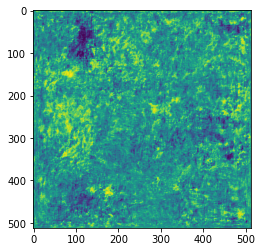

In [47]:
# Print a predicted mask.

pred_mask = np_seg_preds[1, :, :, 0]

print(pred_mask.shape)

plt.imshow(pred_mask)
plt.show()

### Process the seg_model output

tensor(0, dtype=torch.int32)
tensor(1, dtype=torch.int32)
torch.Size([8, 1, 512, 512])


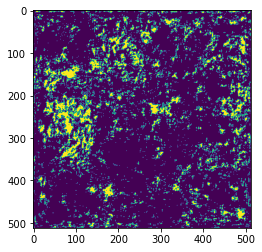

In [48]:
# Threshold the predicted mask
# Note that seg_preds is of type torch tensor because we will use it as input for the reg_model.

threshold = 0.7

thresh_masks = (seg_preds >= threshold).int() # change the dtype of the torch tensor to int32

print(thresh_masks.min())
print(thresh_masks.max())
print(thresh_masks.shape)

plt.imshow(thresh_masks[1, 0, :, :])
plt.show()

In [49]:
# Create the input by multiplying the thresh_masks and the seg_model input images.
# When we mutiply we are selecting only parts of the image that are inside the predicted segmentations.
# All other parts of the image, outside the segmentations, are set to zero i.e. they become black.

# reg_input = thresh_masks * images # This line multiplies torch tensors. 
reg_input = multiply_masks_and_images(images, thresh_masks) # Here the multiplication is done using numpy.

print(reg_input.min())
print(reg_input.max())
print(reg_input.shape)


tensor(-2.1179)
tensor(2.6400)
torch.Size([8, 3, 512, 512])


(8, 512, 512, 3)


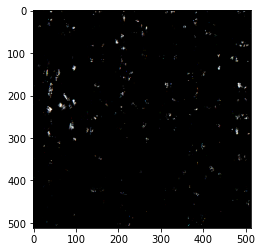

In [50]:
# Convert to numpy so we can use plt to display an image

np_reg_input = reg_input.numpy()

np_reg_input = np_reg_input.reshape((-1, 512, 512, 3))

print(np_reg_input.shape)

image = np_reg_input[1, :, :, :]

plt.imshow(image)

plt.show()

### reg_model

In [51]:
# Here we pass the processed seg_model preds through reg_model.

reg_preds = reg_model(reg_input)

# define the layer as a function
#reg_output = nn.ReLU(inplace=True)
#postive_preds = reg_output(reg_preds)

print(reg_preds.shape)

reg_preds

torch.Size([8, 1])


tensor([[-0.5840],
        [-0.7488],
        [-0.2371],
        [ 0.0765],
        [-0.1199],
        [-0.4873],
        [-0.7502],
        [-0.4306]], grad_fn=<AddmmBackward>)

In [52]:
# loss
reg_criterion = nn.MSELoss()
reg_loss = reg_criterion(reg_preds, targets).item()

reg_loss

3240.49072265625

We have tested both models and are sure that they work. Now we need to combine both models into a single training loop that includes the loss functions and the optimizers.

## Model Architecture

We will train two models at the same time but independently. The ouput from the seg model will be thresholded, multiplied by the input image and then fed into the reg model. Each model will have its own loss function and optimizer. The models will be trained inside the same training loop.

## Set up the Training Loop

In [53]:
# Initialize the dataloaders

train_data = CompDataset(df_train, augmentation=get_training_augmentation(), 
                        preprocessing=get_preprocessing(preprocessing_fn))

# Note that we are not augmenting the validation images.
val_data = CompDataset(df_val, augmentation=None, 
                        preprocessing=get_preprocessing(preprocessing_fn))


train_loader = torch.utils.data.DataLoader(train_data,
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                           num_workers=NUM_CORES
                                            )

val_loader = torch.utils.data.DataLoader(val_data,
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                           num_workers=NUM_CORES
                                            )

In [54]:
# send the model to the device
seg_model.to(device)
reg_model.to(device)

# instantiate the optimizers
seg_optimizer = torch.optim.Adam(seg_model.parameters(), lr=LRATE)
reg_optimizer = torch.optim.Adam(reg_model.parameters(), lr=LRATE)

# define the loss functions
seg_criterion = smp.utils.losses.DiceLoss()
reg_criterion = nn.MSELoss()


seg_val_loss_list = []
reg_val_loss_list = []


for epoch in range(0, NUM_EPOCHS):
    
    print('\n') 
    print('Epoch:', epoch)
    print('Train steps:', len(train_loader))
    
    
    # ====================
    # TRAINING
    # ====================
    
    # Set the Mode
    seg_model.train()
    reg_model.train()
    
    # Turn gradient calculations on.
    torch.set_grad_enabled(True)
    
    epoch_loss = 0
    seg_epoch_loss = 0
    reg_epoch_loss = 0
    
    for i, batch in enumerate(train_loader):
        
        
        print(i, end="\r") 

        
        # Get a batch and send to device
        images, masks, reg_targets = batch
        
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.float)
        reg_targets = reg_targets.squeeze(dim=1)
        reg_targets = reg_targets.to(device, dtype=torch.float)
        
        
        
        # (1) SEGMENTATION MODEL
        # .......................
        
        
        # pass the input through the model
        seg_preds = seg_model(images)
        
        # calculate the loss
        seg_loss = seg_criterion(seg_preds, masks)
        
        
        seg_optimizer.zero_grad()
        
        seg_loss.backward() # Calculate Gradients
        seg_optimizer.step() # Update Weights
        
        # accumulate the loss for the epoch
        seg_epoch_loss = seg_epoch_loss + seg_loss.item()
        
        
        # (2) PROCESS SEGMENTATION MODEL OUTPUT
        # ......................................
        
        # threshold the predicted segmentation masks
        thresh_masks = (seg_preds >= THRESHOLD).int()
        
        # Multiply the thresholded masks by the RGB images.
        # The result will be an image with 3 channels.
        # The wheat heads that are inside the segmentation will
        # be visible. Everything else on the image will be black.
        #seg_output_masks = thresh_masks * images
        
        # do the multiplication with numpy
        seg_output_masks = multiply_masks_and_images(images, thresh_masks)
        
        # send the masks to the device
        seg_output_masks = seg_output_masks.to(device, dtype=torch.float)
        
        
        # (3) REGRESSION MODEL
        # .....................
        
        # pass the input through the model
        reg_preds = reg_model(seg_output_masks)
        
        # calculate the loss
        reg_preds = reg_preds.squeeze(dim=1)
        
        reg_loss = reg_criterion(reg_preds, reg_targets)
        
        
        reg_optimizer.zero_grad()
        
        reg_loss.backward() # Calculate Gradients
        reg_optimizer.step() # Update Weights
        
        # accumulate the loss for the epoch
        reg_epoch_loss = reg_epoch_loss + reg_loss.item()
        
      
    # get the avarage loss for the epoch
    seg_avg_loss = seg_epoch_loss/len(train_loader)
    reg_avg_loss = reg_epoch_loss/len(train_loader)

    print('Train dice loss:', seg_avg_loss)
    print('Train mse loss:', reg_avg_loss)
    #print('\n')
    
    
    
    
    
    
    # ====================
    # VALIDATION
    # ====================
    
    # Set the Mode
    seg_model.eval()
    reg_model.eval()
    
    # Turn gradient calculations off.
    torch.set_grad_enabled(False)
    
    epoch_loss = 0
    seg_epoch_loss = 0
    reg_epoch_loss = 0
    
    print('---')
    print('Val steps:', len(val_loader))
    
    for i, batch in enumerate(val_loader):
        
        print(i, end="\r") 

        
        # Get a batch and send to device
        images, masks, reg_targets = batch
        
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.float)
        reg_targets = reg_targets.squeeze(dim=1)
        reg_targets = reg_targets.to(device, dtype=torch.float)
        
        
        
        # (1) SEGMENTATION MODEL
        # .......................
        
        
        # pass the input through the model
        seg_preds = seg_model(images)
        
        # calculate the loss
        seg_loss = seg_criterion(seg_preds, masks)
        
        
        # accumulate the loss for the epoch
        seg_epoch_loss = seg_epoch_loss + seg_loss.item()
        
        
        # (2) PROCESS SEGMENTATION MODEL OUTPUT
        # ......................................
        
        # threshold the predicted segmentation masks
        thresh_masks = (seg_preds >= THRESHOLD).int()
        
        # Multiply the thresholded masks by the RGB images.
        # The result will be an image with 3 channels.
        # The wheat heads that are inside the segmentation will
        # be visible. Everything else on the image will be black.
        #seg_output_masks = thresh_masks * images
        
        # do the multiplication with numpy
        seg_output_masks = multiply_masks_and_images(images, thresh_masks)
        
        # send the masks to the device
        seg_output_masks = seg_output_masks.to(device, dtype=torch.float)
        
        
        # (3) REGRESSION MODEL
        # .....................
        
        # pass the input through the model
        reg_preds = reg_model(seg_output_masks)
        
        # calculate the loss
        reg_preds = reg_preds.squeeze(dim=1)
        
        reg_loss = reg_criterion(reg_preds, reg_targets)
        
        
        # accumulate the loss for the epoch
        reg_epoch_loss = reg_epoch_loss + reg_loss.item()
        
      
    # get the avarage loss for the epoch
    seg_avg_loss = seg_epoch_loss/len(val_loader)
    reg_avg_loss = reg_epoch_loss/len(val_loader)
    

    print('Val dice loss:', seg_avg_loss)
    print('Val mse loss:', reg_avg_loss)
    
    
    
    # Save the models
    # ----------------
    
    if epoch == 0:
        
        # save both models
        torch.save(seg_model.state_dict(), 'seg_model.pt')
        torch.save(reg_model.state_dict(), 'reg_model.pt')
        print('Both models saved.')
        
        
    if epoch != 0:
        
        # Be sure to calculate these variables before 
        # appending the new loss values to the lists.
        best_val_seg_avg_loss = min(seg_val_loss_list)
        best_val_reg_avg_loss = min(reg_val_loss_list)
 
        if seg_avg_loss < best_val_seg_avg_loss:
            # save the model
            torch.save(seg_model.state_dict(), 'seg_model.pt')
            print('Val dice loss improved. Saved model as seg_model.pt')
      
        if reg_avg_loss < best_val_reg_avg_loss:
            # save the model
            torch.save(reg_model.state_dict(), 'reg_model.pt')
            print('Val mse loss improved. Saved model as reg_model.pt')
            
            
    # append the loss values to the lists   
    seg_val_loss_list.append(seg_avg_loss)
    reg_val_loss_list.append(reg_avg_loss)
    



Epoch: 0
Train steps: 372
Train dice loss: 0.31365486322551644
Train mse loss: 1258.0587233599797
---
Val steps: 49
Val dice loss: 0.2416027103151594
Val mse loss: 193.07676494364836
Both models saved.


Epoch: 1
Train steps: 372
Train dice loss: 0.2064734386500492
Train mse loss: 354.7415549934551
---
Val steps: 49
Val dice loss: 0.21315500565937587
Val mse loss: 116.7154839963329
Val dice loss improved. Saved model as seg_model.pt
Val mse loss improved. Saved model as reg_model.pt


Epoch: 2
Train steps: 372
Train dice loss: 0.18299093265687266
Train mse loss: 148.33447605307384
---
Val steps: 49
Val dice loss: 0.19769295624324254
Val mse loss: 89.88442658404915
Val dice loss improved. Saved model as seg_model.pt
Val mse loss improved. Saved model as reg_model.pt


Epoch: 3
Train steps: 372
Train dice loss: 0.17156504158691693
Train mse loss: 137.26203694907568
---
Val steps: 49
Val dice loss: 0.19314203456956514
Val mse loss: 55.15456904197226
Val dice loss improved. Saved model a

In [55]:
# Check that the models have been saved.

!ls

__notebook__.ipynb  df_test.csv.gz   df_val.csv.gz  seg_model.pt
df_data.csv.gz	    df_train.csv.gz  reg_model.pt


## Make a prediction on the val set

In [56]:
# Load the saved models
seg_model.load_state_dict(torch.load('seg_model.pt'))
reg_model.load_state_dict(torch.load('reg_model.pt'))

# Make a prediction on the val set
for i, batch in enumerate(val_loader):
        
        print(i, end="\r") 

        
        # Get a batch and send to device
        images, masks, reg_targets = batch
        
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.float)
        reg_targets = reg_targets.squeeze(dim=1)
        reg_targets = reg_targets.to(device, dtype=torch.float)
        
        
        
        # (1) SEGMENTATION MODEL
        # .......................
        
        
        # pass the input through the model
        seg_preds = seg_model(images)
        
        
        
        # (2) PROCESS SEGMENTATION MODEL OUTPUT
        # ......................................
        
        # threshold the predicted segmentation masks
        thresh_masks = (seg_preds >= THRESHOLD).int()
        
        # Multiply the thresholded masks by the RGB images.
        # The result will be an image with 3 channels.
        # The wheat heads that are inside the segmentation will
        # be visible. Everything else on the image will be black.
        #seg_output_masks = thresh_masks * images
        
        # do the multiplication with numpy
        seg_output_masks = multiply_masks_and_images(images, thresh_masks)
        
        # send the masks to the device
        seg_output_masks = seg_output_masks.to(device, dtype=torch.float)
        
        
        # (3) REGRESSION MODEL
        # .....................
        
        # pass the input through the model
        reg_preds = reg_model(seg_output_masks)
        
        
        
         # Stack the predictions from each batch
        if i == 0:
            stacked_images = images
            stacked_masks = masks
            #stacked_thresh_masks = thresh_masks
            stacked_reg_targets = reg_targets
            
            
            stacked_seg_preds = seg_preds
            stacked_seg_output_masks = seg_output_masks
            stacked_reg_preds = reg_preds
            
        else:
            
            stacked_images = torch.cat((stacked_images, images), dim=0)
            stacked_masks = torch.cat((stacked_masks, masks), dim=0)
            #stacked_thresh_masks = torch.cat((stacked_thresh_masks, thresh_masks), dim=0)
            
            stacked_reg_targets = torch.cat((stacked_reg_targets, reg_targets), dim=0)
            
            stacked_seg_preds = torch.cat((stacked_seg_preds, seg_preds), dim=0)
            stacked_seg_output_masks = torch.cat((stacked_seg_output_masks, seg_output_masks), dim=0)
            stacked_reg_preds = torch.cat((stacked_reg_preds, reg_preds), dim=0)
            
# True    
print(stacked_images.shape)
print(stacked_masks.shape)
#print(stacked_thresh_masks.shape)
print(stacked_reg_targets.shape)
print('\n')

# Predicted
print(stacked_seg_preds.shape)
print(stacked_seg_output_masks.shape)
print(stacked_reg_preds.shape)

torch.Size([389, 3, 512, 512])
torch.Size([389, 1, 512, 512])
torch.Size([389])


torch.Size([389, 1, 512, 512])
torch.Size([389, 3, 512, 512])
torch.Size([389, 1])


In [57]:
# Convert to numpy

np_stacked_images = stacked_images.cpu().numpy() ##
np_stacked_masks = stacked_masks.cpu().numpy() ##
#np_stacked_thresh_masks = stacked_thresh_masks.cpu().numpy()

np_stacked_seg_preds = stacked_seg_preds.cpu().numpy()
np_stacked_seg_output_masks = stacked_seg_output_masks.cpu().numpy() ##

# reshape to channels first
np_stacked_images = np_stacked_images.reshape((-1, 512, 512, 3)) ##
np_stacked_masks = np_stacked_masks.reshape((-1, 512, 512, 1)) ##
#np_stacked_thresh_masks = np_stacked_thresh_masks.reshape((-1, 512, 512, 1))

np_stacked_seg_preds = np_stacked_seg_preds.reshape((-1, 512, 512, 1))
np_stacked_seg_output_masks = np_stacked_seg_output_masks.reshape((-1, 512, 512, 3)) ##

#print(np_stacked_images.shape)
#print(np_stacked_masks.shape)
#print(np_stacked_thresh_masks.shape)
#print(np_stacked_seg_preds.shape)
#print(np_stacked_seg_output_masks.shape)

## Display the seg_model predicted masks and the reg_model input images

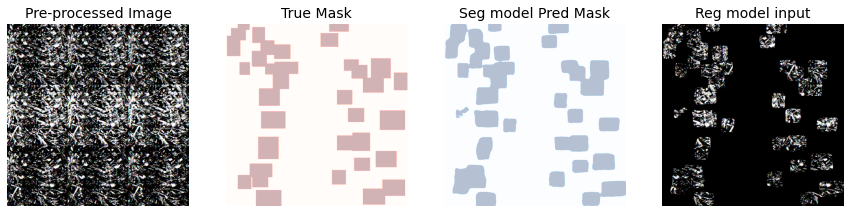

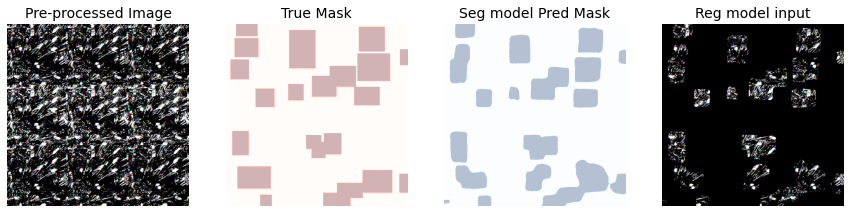

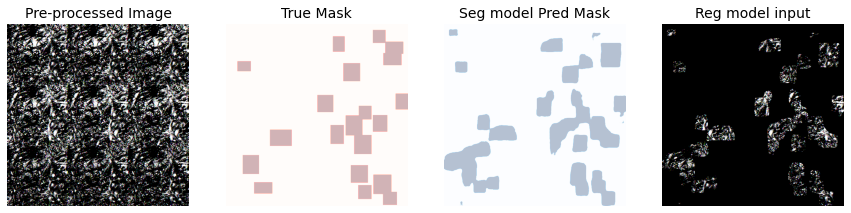

In [58]:
for index in range(1, 4):

    # set up the canvas for the subplots
    plt.figure(figsize=(15,15))
    plt.tight_layout()
    plt.axis('off')



    plt.subplot(1,4,1)
    true_image = np_stacked_images[index, :, :, :]
    plt.imshow(true_image)
    plt.title('Pre-processed Image', fontsize=14)
    plt.axis('off')

    plt.subplot(1,4,2)
    true_mask = np_stacked_masks[index, :, :, 0]
    plt.imshow(true_mask, cmap='Reds', alpha=0.3)
    plt.title('True Mask', fontsize=14)
    plt.axis('off')

    plt.subplot(1,4,3)
    pred_mask = np_stacked_seg_preds[index, :, :, 0]
    plt.imshow(pred_mask, cmap='Blues', alpha=0.3)
    plt.title('Seg model Pred Mask', fontsize=14)
    plt.axis('off')
    
    plt.subplot(1,4,4)
    pred_mask = np_stacked_seg_output_masks[index, :, :, :]
    #thresh_mask = np_stacked_thresh_masks[index, :, :, 0]
    
    plt.imshow(pred_mask)
    #plt.imshow(thresh_mask, cmap='Reds', alpha=0.3)
    plt.title('Reg model input', fontsize=14)
    plt.axis('off')

    plt.show()
    

## Analyze the regression predictions

In [59]:
# Change to numpy

np_stacked_reg_targets = stacked_reg_targets.cpu().numpy()

np_stacked_reg_preds = stacked_reg_preds.cpu().numpy()
np_stacked_reg_preds = np_stacked_reg_preds.squeeze()

#print(np_stacked_reg_targets.shape)
#print(np_stacked_reg_preds.shape)



# Add the predictions to a dataframe

df_val['true_count'] = np_stacked_reg_targets

df_val['pred_count'] = np_stacked_reg_preds


# Create more columns

df_val['pred_error'] = df_val['true_count'] - df_val['pred_count']

df_val['abs_error'] = df_val['pred_error'].apply(abs)

df_val['percent_error'] = (df_val['abs_error']/df_val['num_masks'])*100



cols = ['image_id', 'num_masks', 'true_count', 'pred_count', 'pred_error', 'abs_error']
df = df_val[cols]

#df.head(10)

## Images with < 10% count error

110 of 389 val images have < 10% error.


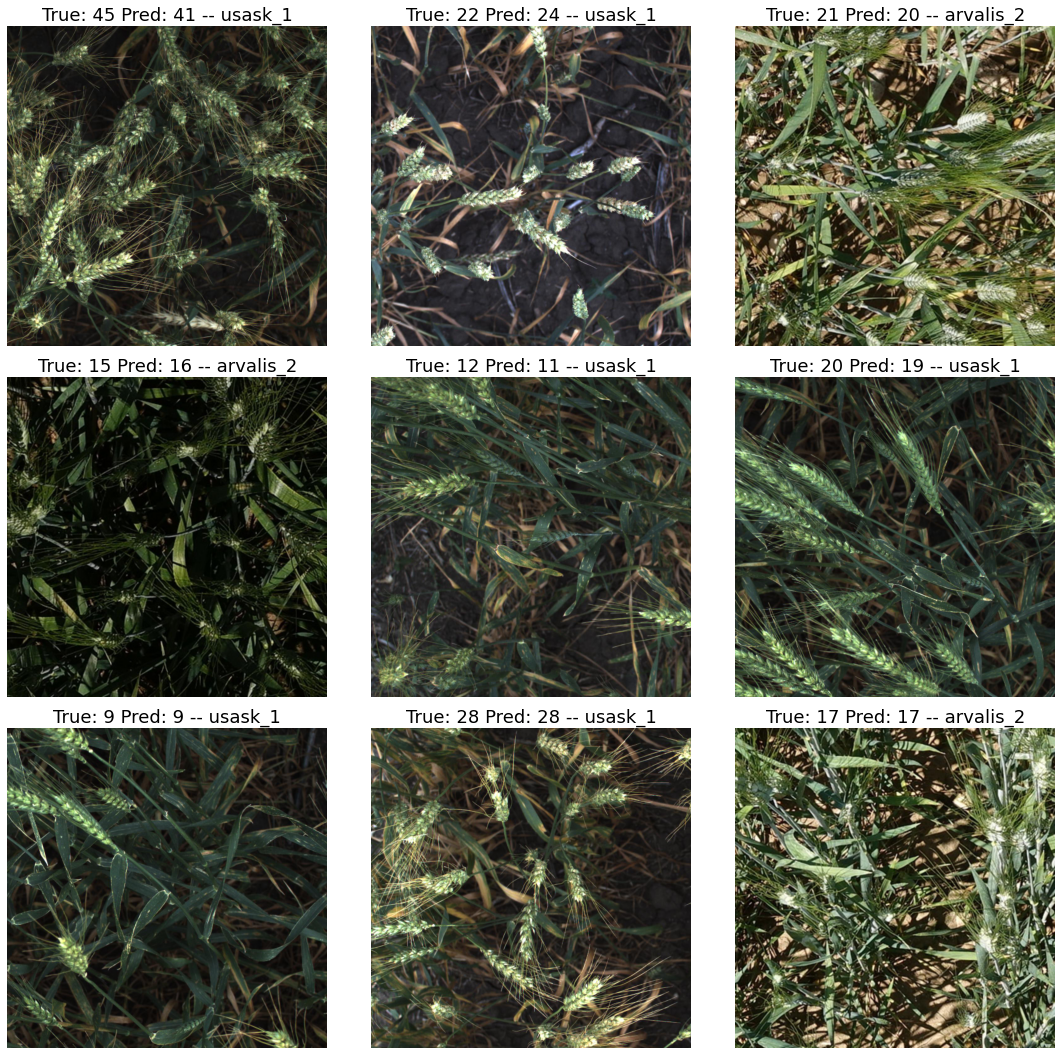

In [60]:
df = df_val[df_val['percent_error'] < 10]

message = str(len(df)) + ' of 389 val images have < 10% error.'

print(message)

df = df.reset_index(drop=True)

# set up the canvas for the subplots
plt.figure(figsize=(15,15))

plt.subplot(3,4,1)

# Our subplot will contain 3 rows and 3 columns
# plt.subplot(nrows, ncols, plot_number)


for i in range(1, 10):
    
    # image
    plt.subplot(3,3,i)

    path = base_path + 'train/' + df.loc[i, 'image_id'] + '.jpg'
    image = plt.imread(path)

    true = df.loc[i, 'num_masks']

    # round the pred
    pred = round(df.loc[i, 'pred_count'], 0)
    # convert to type int
    pred = int(pred)

    source = df.loc[i, 'source']
    
    result = 'True: ' + str(true) + ' Pred: ' + str(pred) + ' -- ' + source
    
    plt.imshow(image)
    plt.title(result, fontsize=18)
    #plt.xlabel(source, fontsize=10)
    plt.tight_layout()
    plt.axis('off')


The results above demonstrate that this model is capable of counting with high levels of accuracy.

## Images with > 50% count error

13 of 389 val images have > 50% error.


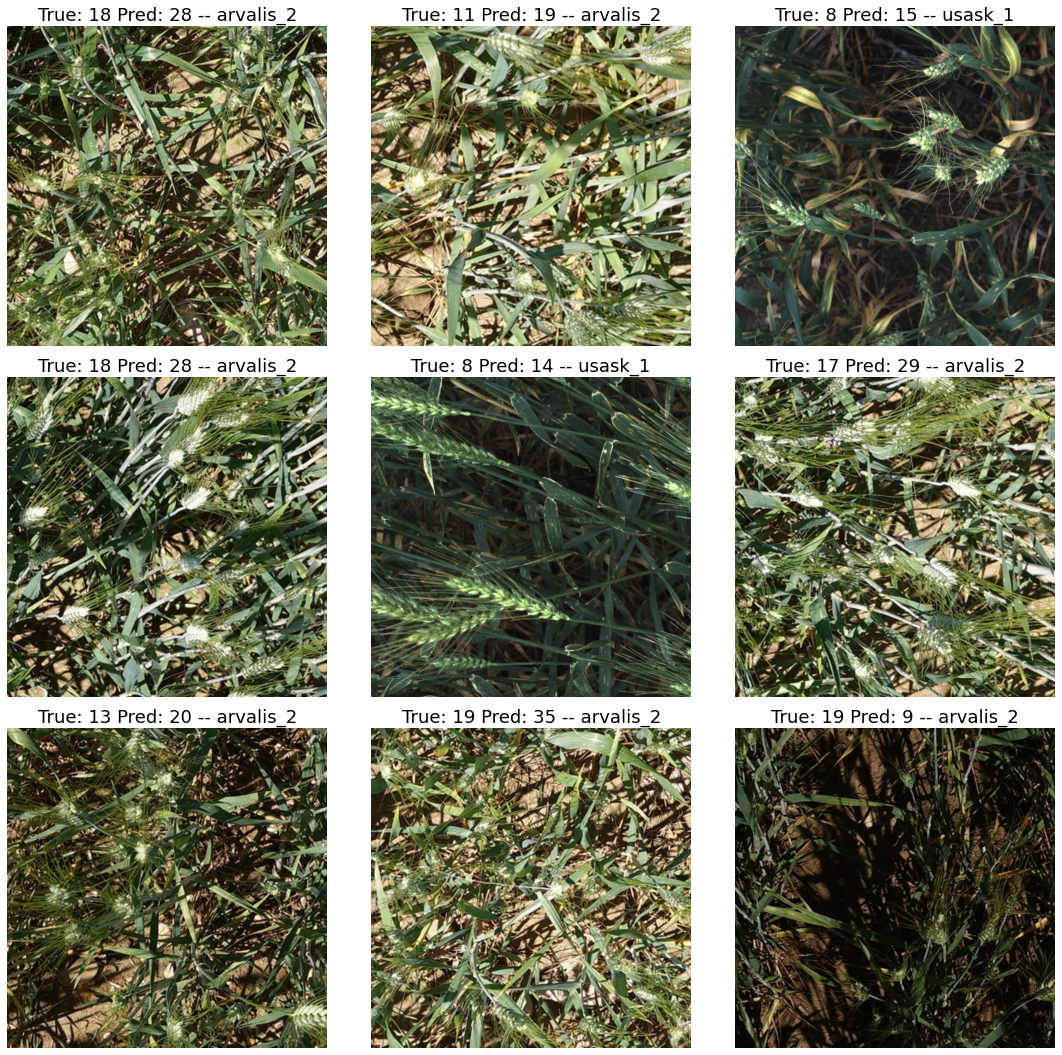

In [61]:
df = df_val[df_val['percent_error'] > 50]

message = str(len(df)) + ' of 389 val images have > 50% error.'

print(message)

df = df.reset_index(drop=True)

# set up the canvas for the subplots
plt.figure(figsize=(15,15))

plt.subplot(3,4,1)

# Our subplot will contain 3 rows and 3 columns
# plt.subplot(nrows, ncols, plot_number)


for i in range(1, 10):
    
    # image
    plt.subplot(3,3,i)

    path = base_path + 'train/' + df.loc[i, 'image_id'] + '.jpg'
    image = plt.imread(path)

    true = df.loc[i, 'num_masks']

    # round the pred
    pred = round(df.loc[i, 'pred_count'], 0)
    # convert to type int
    pred = int(pred)

    source = df.loc[i, 'source']
    
    result = 'True: ' + str(true) + ' Pred: ' + str(pred) + ' -- ' + source
    
    plt.imshow(image)
    plt.title(result, fontsize=18)
    #plt.xlabel(source, fontsize=10)
    plt.tight_layout()
    plt.axis('off')


On the above images the wheat heads are not clearly distinguishable at first glance. This could be why the model is producing a counting error greater than 50%. Even a human would struggle to produce accurate wheat head counts for many of these images. What's encouraging is that the number of validation images with an error greater than 50% is low. On different experiements I've observed that this number is usually less than 60 of the 389 validation images.

## Val Set Percentage Error

In [62]:
print('Total val percentage error:', (df_val['abs_error'].sum()/df_val['true_count'].sum()) * 100)

Total val percentage error: 19.485024678124365


## Mean Absolute Error (MAE)

MAE is a metric that's easy to understand and to explain because the scale of the error is the same as the scale of the target.

In [63]:
# Put the rows from each region into separate dataframes

df_usask_1 = df_val[df_val['source'] == 'usask_1']
df_arvalis_2 = df_val[df_val['source'] == 'arvalis_2']

In [64]:
# Check the prediction error stats for the entire val set
print('MAE for all validation data:')
print('Val set MAE:', df_val['abs_error'].mean())
print('')
print('MAE by source:')
print('usask_1 MAE:', df_usask_1['abs_error'].mean())
print('arvalis_2 MAE:', df_arvalis_2['abs_error'].mean())

MAE for all validation data:
Val set MAE: 4.785101304630388

MAE by source:
usask_1 MAE: 5.700467561810745
arvalis_2 MAE: 3.883745755468096


In [65]:
# Save df_val for future analysis

df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

In [66]:
# Check if the dataframe was saved.
!ls

__notebook__.ipynb  df_test.csv.gz   df_val.csv.gz  seg_model.pt
df_data.csv.gz	    df_train.csv.gz  reg_model.pt


## Reference Notebooks

- Segmentation tutorial by Pavel Yakubovsky<br>
https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

- Simple Cell Counter - Keras CNN<br>
https://www.kaggle.com/vbookshelf/simple-cell-counter-with-web-interface

- Bert as a Microservice - Flask App<br>
https://www.kaggle.com/vbookshelf/bert-as-a-microservice-flask-app

## Helpful Resources

- Segmentation Models Pytorch package<br>
https://github.com/qubvel/segmentation_models.pytorch

- Forum post by Chris Deotte on the segmentation models package.<br>
https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/103367

- Codebasics tutorial on dataframe merging<br>
https://www.youtube.com/watch?v=h4hOPGo4UVU

- Deeplizard Pytorch tutorial<br>
https://deeplizard.com/learn/video/v5cngxo4mIg

- Deeplizard flask video tutorial<br>
https://deeplizard.com/learn/video/SI1hVGvbbZ4

- Julian Nash docker and flask video tutorial<br>
https://www.youtube.com/watch?v=dVEjSmKFUVI

- How to use SSH to connect to a web server<br>
https://www.youtube.com/watch?v=B_lZt9_9UCc

- Free Udemy Docker course<br>
https://www.udemy.com/course/docker-essentials/





## Conclusion

This project has been very challenging. Many thanks to the competition hosts for presenting this interesting problem to the Kaggle community. Thanks Kaggle for the free GPU.

Thank you for reading.